In [3]:

import models
import utils
import data_processing
from constants import (
    VALUE_COLUMN,
    UNIT_RATE_COLUMN,
    QUANTITY_COLUMN,
    GROSS_WEIGHT_COLUMN,
    SHIP_COUNT_COLUMN,
    PORT_COUNT_COLUMN,
    FILL_METHOD,
    TARGET_COLUMN,
    VOLZA_COLUMNS,
    AIS_COLUMNS,
    OIL_COLUMNS,
    ARIMA_RESIDUAL_COLUMN,
    RANDOM_STATE
)
import pandas as pd
import constants
import sys
from datetime import datetime
from build_data import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
import numpy as np

In [4]:
COMMODITY = "magnesium"
WINDOW_SIZE = 20

VOLZA_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}.csv"
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"

# Get the data
data = get_data(VOLZA_FILE_PATH, PRICE_FILE_PATH, window_size=20, center=False)

# Add Isolation Forest spikes column
data['spikes_if'] = utils.detect_spikes_if(data, TARGET_COLUMN, contamination=0.1)

# # Add Bowen's spike detection
# data["spikes_new"] = utils.detect_spikes_new(data, TARGET_COLUMN, window_size=WINDOW_SIZE)

# TRAIN_SIZE = 0.5

Building data...
Rows dropped due to NaN values: 1


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={"Value": "Brent Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={"Value": "WTI Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

Detecting spikes... 20


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [5]:
import matplotlib.pyplot as plt

aggregated_df = data.copy()
data.head(2)

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if
1,2020-01-02,112499.980000,50000.00,50080.0,2.250000,14150.0,67.05,61.17,14150.000000,0,0
2,2020-01-03,874407.619695,100172.26,25040.0,768.449153,14100.0,69.08,63.00,-1453.965633,0,0


In [6]:
# Add Lagged Features
aggregated_df = utils.add_lagged_features(aggregated_df, 'Price', n_lags=5)

# Add Moving Averages
aggregated_df = utils.add_moving_averages(aggregated_df, 'Price', windows=[5, 10])

# Add Returns
aggregated_df = utils.add_returns(aggregated_df, 'Price')

# Add Volatility
aggregated_df = utils.add_volatility(aggregated_df, 'returns', windows=[7, 14])

KeyError: 'spikes_new'

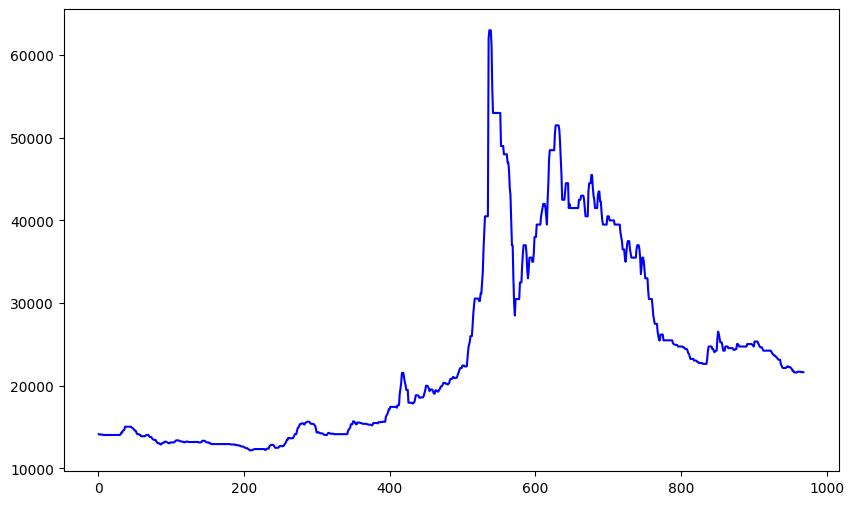

In [7]:
import matplotlib.pyplot as plt
# Plotting the price data
utils.plot_prices(aggregated_df,column='spikes_new')

In [ ]:
PRICE_FEATURE_COLUMNS = ['ma_5', 'ma_10', 'returns']
PRICE_LAG_FEATURE_COLUMNS = ['lag_1', 'lag_2', 'lag_3']
FEATURE_COLUMNS = VOLZA_COLUMNS + OIL_COLUMNS + [ARIMA_RESIDUAL_COLUMN]  # Mix and match features here
SPIKE_COLUMN = ['spikes_new']

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Prepare mixed data
X_mix, y_mix = data_processing.prepare_features_and_target(aggregated_df, FEATURE_COLUMNS, SPIKE_COLUMN)

# Split mixed data
X_train_mix, X_test_mix, y_train_mix, y_test_mix = train_test_split(X_mix, y_mix, test_size=0.3, random_state=RANDOM_STATE, shuffle=False)
X_train_mix, X_val_mix, y_train_mix, y_val_mix = train_test_split(X_train_mix, y_train_mix, test_size=(10/70), random_state=RANDOM_STATE, shuffle=False)  # Adjusting test_size to get ~10% of the original

# Balancing
X_train_mix, y_train_mix = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train_mix, y_train_mix)

# Scaling
X_train_mix, X_test_mix, X_val_mix = data_processing.scale_features(X_train_mix, X_test_mix, X_val_mix)

# Sequence making
X_train_mix, y_train_mix = data_processing.create_sequences(X_train_mix, y_train_mix, WINDOW_SIZE)
X_test_mix, y_test_mix = data_processing.create_sequences(X_test_mix, y_test_mix, WINDOW_SIZE)
X_val_mix, y_val_mix = data_processing.create_sequences(X_val_mix, y_val_mix, WINDOW_SIZE)

# Evaluate and create pre-trained model
output_file_path = f'{COMMODITY}/test/results_test.csv'
pred_file_path = f'{COMMODITY}/test/predictions/test'
model_path = f'{COMMODITY}/best_model'
print(pred_file_path)

results_df, best_acc, best_model_descriptor = models.evaluate_all(X_train_mix, y_train_mix, X_val_mix, y_val_mix, X_test_mix, y_test_mix, output_file_path, pred_file_path, model_path)

copper/test/predictions/test


TypeError: evaluate_all() missing 1 required positional argument: 'pretrain'

In [ ]:
print(f'Best Model: {best_model_descriptor} \nBest Accuracy: {best_acc}')

Best Model: LSTM_256_layers 
Best Accuracy: 0.4


In [ ]:
# Prepare price data
X_price, y_price = data_processing.prepare_features_and_target(aggregated_df, TARGET_COLUMN, SPIKE_COLUMN)

# Split price data
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.3, random_state=RANDOM_STATE, shuffle=False)
X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(X_train_price, y_train_price, test_size=(10/70), random_state=RANDOM_STATE, shuffle=False)

# Balancing
X_train_price, y_train_price = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train_price, y_train_price)

# Scaling
X_train_price, X_test_price, X_val_price = data_processing.scale_features(X_train_price, X_test_price, X_val_price)

# Sequence making
X_train_price, y_train_price = data_processing.create_sequences(X_train_price, y_train_price, WINDOW_SIZE)
X_test_price, y_test_price = data_processing.create_sequences(X_test_price, y_test_price, WINDOW_SIZE)
X_val_price, y_val_price = data_processing.create_sequences(X_val_price, y_val_price, WINDOW_SIZE)

In [ ]:
from tensorflow.keras.models import load_model

saved_model_path = f'{model_path}/{best_model_descriptor}.h5'
model = load_model(saved_model_path)
# model.summary()


In [ ]:
print(X_train_price.shape, X_val_price.shape, X_test_price.shape)
print(X_train_mix.shape, X_val_mix.shape, X_test_mix.shape)

(1445, 20, 1) (105, 20, 1) (353, 20, 1)
(1445, 20, 6) (105, 20, 6) (353, 20, 6)


In [ ]:
results_df = models.retrain_best_model(saved_model_path, X_train_price, y_train_price, X_val_price, y_val_price, X_test_price, y_test_price)

12/12 [==============================] - 0s 6ms/step


In [ ]:
results_df

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),,Prior
0,Retrained Model,LSTM_256_layers,0.971671,0.985632,0.985632,0.985632,0.0,0.0,0.0,0.01
